In [13]:
import intake
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import fsspec
import os
import time
import datetime as dt
import pprint
import pandas as pd
from tqdm import tqdm

import warnings
# normally I dislike ingoring warnings, but there were too many mean of empty slice warnings to be useful
warnings.simplefilter('ignore')

xr.set_options(display_style='html')
%matplotlib inline
%config InlineBackend.figure_format = 'retina' 
plt.rcParams['figure.figsize'] = 12, 6

In [3]:
from dask.distributed import Client

client = Client("tcp://10.32.16.44:40769")
client

Client Scheduler: tcp://10.32.16.44:40769 Dashboard: /user/0000-0003-3746-2383/proxy/8787/status,Cluster Workers: 20 Cores: 40 Memory: 230.00 GB


# Load fgco2 and tos (SST, degrees C, monthly)
as two separate dictionaries

In [4]:
cat_url = "https://storage.googleapis.com/cmip6/pangeo-cmip6.json"
col = intake.open_esm_datastore(cat_url)
cat = col.search(experiment_id=['historical'], variable_id='fgco2',
                 grid_label='gn', table_id='Omon')

dset_dict = {}
for name, group in cat.df.groupby('source_id'):
    dsets = [xr.open_zarr(fsspec.get_mapper(zstore), consolidated=True)
             for zstore in group.zstore.values]
    try:
        dsets_aligned = xr.align(*dsets, join='exact')
        dset_dict[name] = xr.concat(dsets, dim='member')
        print(f'concatted {name}')
    except Exception as e:
        print(f'failed to concat {name}')
        print(e)

concatted ACCESS-ESM1-5
concatted BCC-CSM2-MR
concatted BCC-ESM1
concatted CESM2
concatted CESM2-FV2
concatted CESM2-WACCM
concatted CESM2-WACCM-FV2
concatted CNRM-ESM2-1
concatted CanESM5
concatted CanESM5-CanOE
concatted GISS-E2-1-G
concatted GISS-E2-1-G-CC
concatted IPSL-CM6A-LR
concatted MIROC-ES2L
concatted MPI-ESM-1-2-HAM
concatted MPI-ESM1-2-HR
concatted MPI-ESM1-2-LR
concatted MRI-ESM2-0
concatted NorCPM1
concatted NorESM2-LM
concatted NorESM2-MM
failed to concat UKESM1-0-LL
indexes along dimension 'time' are not equal


In [5]:
cat = col.search(experiment_id=['historical'], variable_id='tos',
                 grid_label='gn', table_id='Omon')

dset_dict_tos = {}
for name, group in cat.df.groupby('source_id'):
    if name in dset_dict.keys():
        dsets = [xr.open_zarr(fsspec.get_mapper(zstore), consolidated=True)
                 for zstore in group.zstore.values]
        try:
            dsets_aligned = xr.align(*dsets, join='exact')
            dset_dict_tos[name] = xr.concat(dsets, dim='member')
            print(f'concatted {name}')
        except Exception as e:
            print(f'failed to concat {name}')
            print(e)
    else:
        None

concatted ACCESS-ESM1-5
concatted BCC-CSM2-MR
concatted BCC-ESM1
concatted CESM2
concatted CESM2-FV2
concatted CESM2-WACCM
concatted CESM2-WACCM-FV2
concatted CNRM-ESM2-1
concatted CanESM5
concatted CanESM5-CanOE
concatted GISS-E2-1-G
concatted GISS-E2-1-G-CC
concatted IPSL-CM6A-LR
concatted MIROC-ES2L
concatted MPI-ESM-1-2-HAM
concatted MPI-ESM1-2-HR
concatted MPI-ESM1-2-LR
concatted MRI-ESM2-0
concatted NorCPM1
concatted NorESM2-LM
concatted NorESM2-MM


In [6]:
ddict_super={'fgco2':dset_dict, 'tos':dset_dict_tos}

In [7]:
info = {}

for model in dset_dict.keys():
    info[model] = {}

# catalog the dimension and coordinate labels used in each model into a new dictionary
for key in dset_dict.keys():
    # longitude dimensions
    if dset_dict[key].dims.__contains__('j'):
        info[key]['dim_lon'] = 'j'
    elif dset_dict[key].dims.__contains__('x'):
        info[key]['dim_lon'] = 'x'
    elif dset_dict[key].dims.__contains__('lon'):
        info[key]['dim_lon'] = 'lon'
    elif dset_dict[key].dims.__contains__('nlon'):
        info[key]['dim_lon'] = 'nlon'
    else:
        print('dimension label unaccounted for')
    # latitude dimensions
    if dset_dict[key].dims.__contains__('i'):
        info[key]['dim_lat'] = 'i'
    elif dset_dict[key].dims.__contains__('y'):
        info[key]['dim_lat'] = 'y'
    elif dset_dict[key].dims.__contains__('lat'):
        info[key]['dim_lat'] = 'lat'
    elif dset_dict[key].dims.__contains__('nlat'):
        info[key]['dim_lat'] = 'nlat'
    else:
        print('dimension label unaccounted for', key)
    # longitude coordinates
    if dset_dict[key].coords.__contains__('longitude'):
        info[key]['coords_lon'] = 'longitude'
    elif dset_dict[key].coords.__contains__('lon'):
        info[key]['coords_lon'] = 'lon'
    elif dset_dict[key].coords.__contains__('x'):
        info[key]['coords_lon'] = 'x'
    elif dset_dict[key].coords.__contains__('nav_lon'):
        info[key]['coords_lon'] = 'nav_lon'
    else:
        print('coordinate label unnacounted for', key)
    # latitude coordinates
    if dset_dict[key].coords.__contains__('latitude'):
        info[key]['coords_lat'] = 'latitude'
    elif dset_dict[key].coords.__contains__('lat'):
        info[key]['coords_lat'] = 'lat'
    elif dset_dict[key].coords.__contains__('y'):
        info[key]['coords_lat'] = 'y'
    elif dset_dict[key].coords.__contains__('nav_lat'):
        info[key]['coords_lat'] = 'nav_lat'
    else:
        print('coordinate label unnacounted for', key)

# Region of interest: cold tongue
> from the date line to the coast, and 5S to 5N

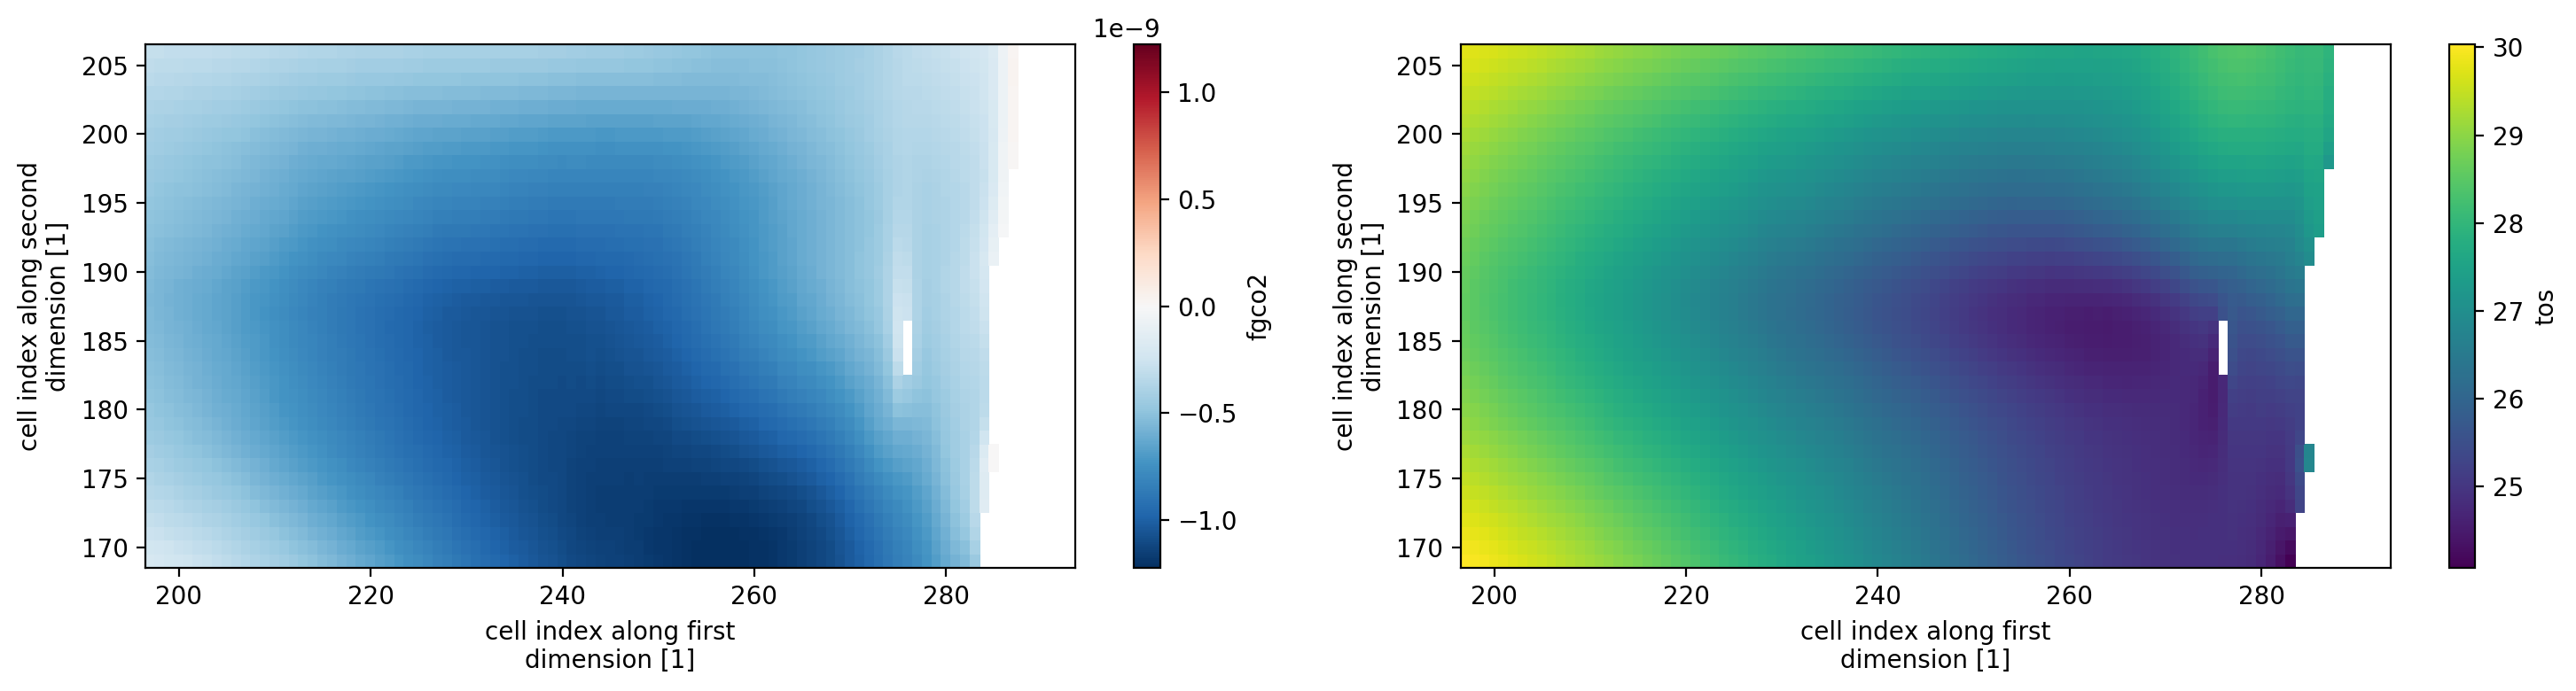

In [257]:
fig, ax = plt.subplots(figsize=(15,4),dpi=100,ncols=2,nrows=1)

ds_fgco2 = ddict_super['fgco2']['CESM2']
ds_fgco2 = ds_fgco2.where((ds_fgco2[coords_lat] < 5) & (ds_fgco2[coords_lat] > -5)
                              & (ds_fgco2[coords_lon] > 180) & (ds_fgco2[coords_lon] < 290),drop=True)
ds_fgco2.fgco2.sel(time='1996',method='nearest').mean(dim=['member','time']).load().plot(ax=ax[0])


ds_tos = ddict_super['tos']['CESM2']
ds_tos = ds_tos.where((ds_tos[coords_lat] < 5) & (ds_tos[coords_lat] > -5)
                              & (ds_tos[coords_lon] > 180) & (ds_tos[coords_lon] < 290),drop=True)
ds_tos.tos.sel(time='1996',method='nearest').mean(dim=['member','time']).load().plot(ax=ax[1])
plt.tight_layout()

# Moving mean

In [62]:
window = 70
for key in tqdm(info.keys()):
# key = 'CESM2'

    coords_lon = info[key]['coords_lon']
    coords_lat = info[key]['coords_lat']
    dim_lat = info[key]['dim_lat']
    dim_lon = info[key]['dim_lon']

    ds_fgco2 = ddict_super['fgco2'][key]
    ds_tos = ddict_super['tos'][key]
    ds_fgco2 = ds_fgco2.where((ds_fgco2[coords_lat] < 5) & (ds_fgco2[coords_lat] > -5)
                              & (ds_fgco2[coords_lon] > 180) & (ds_fgco2[coords_lon] < 290),drop=True)
    ds_tos = ds_tos.where((ds_tos[coords_lat] < 5) & (ds_tos[coords_lat] > -5)
                              & (ds_tos[coords_lon] > 180) & (ds_tos[coords_lon] < 290),drop=True)

    # 12154 km from 180 to 290E, at +/- 5 latitude
    # 1105.7 km from 5N to 5S
    A = 1105.7e3 * 12154e3 # m2
    s2yr = 3600*24*365 # convert from per second to per year

    # select fgco2 variable and convert units from kg/m2/s to Pg C/yr
    ds_fgco2 = ds_fgco2.fgco2 * A * s2yr * 1e-12
    ds_tos = ds_tos.tos
    
    result = ds_fgco2.resample(time='1Y').mean().chunk({'time':-1}).rolling(time=window,center=True).mean().load()
    result = result.mean(dim='member')
    result = result.mean(dim=[dim_lat,dim_lon]).dropna(dim='time')
    
    result_t = ds_tos.resample(time='1Y').mean().chunk({'time':-1}).rolling(time=window,center=True).mean().load()
    result_t = result_t.mean(dim='member')    
    result_t = result_t.mean(dim=[dim_lat,dim_lon]).dropna(dim='time')

    info[key][str(window)+'yr_mean_fgco2'] = result
    info[key][str(window)+'yr_mean_tos'] = result_t

100%|██████████| 21/21 [05:58<00:00, 17.08s/it]


Text(0.57, 0.8, 'CESM2')

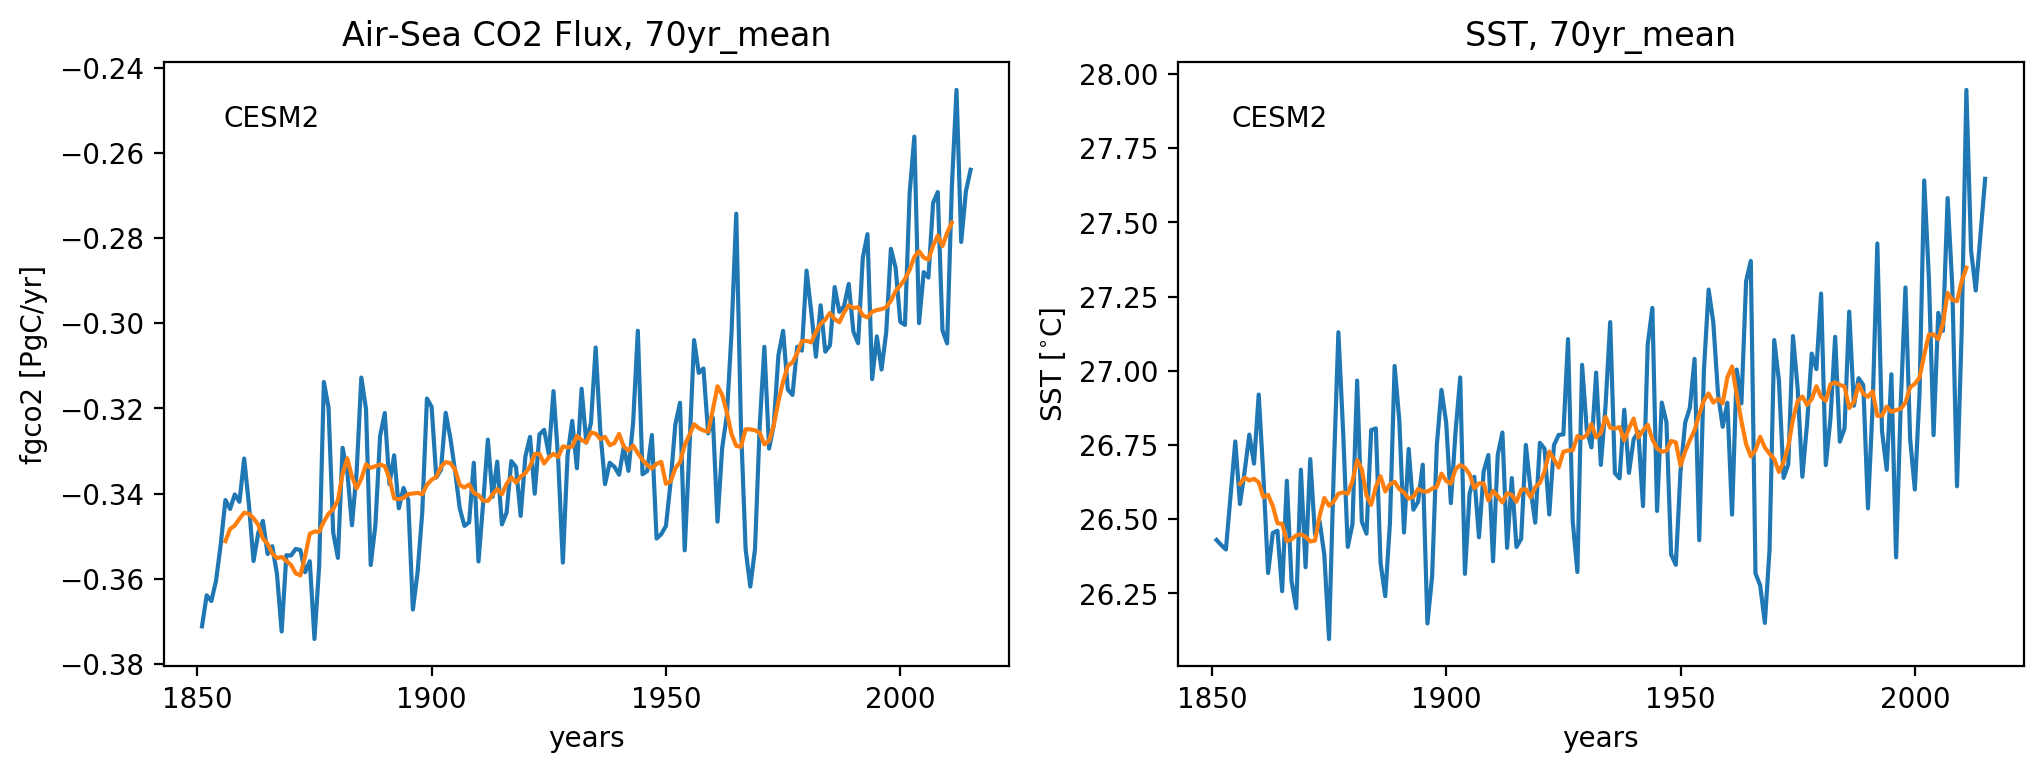

In [231]:
fig, ax = plt.subplots(figsize=(12,4),dpi=100,ncols=2,nrows=1)

info['CESM2']['1yr_mean_fgco2'].plot(ax=ax[0])
info['CESM2']['1yr_mean_fgco2'].rolling(time=10, center=True).mean().plot(ax=ax[0])
ax[0].set_title('Air-Sea CO2 Flux, '+trend)
ax[0].set_xlabel('years')
ax[0].set_ylabel('fgco2 [PgC/yr]')

info['CESM2']['1yr_mean_tos'].plot(ax=ax[1])
info['CESM2']['1yr_mean_tos'].rolling(time=10, center=True).mean().plot(ax=ax[1])
ax[1].set_title('SST, '+trend)
ax[1].set_xlabel('years')
ax[1].set_ylabel('SST [$^{\circ}$C]')

fig.text(0.15,.8,'CESM2')
fig.text(0.57,.8,'CESM2')

# Let's look at the standard deviations, and some other stats

In [158]:
key = 'CESM2'

coords_lon = info[key]['coords_lon']
coords_lat = info[key]['coords_lat']
dim_lat = info[key]['dim_lat']
dim_lon = info[key]['dim_lon']

ds = ddict_super['tos']['CESM2'].mean(dim='member').load()
ds = ds.where((ds[coords_lat] < 5) & (ds[coords_lat] > -5)
                              & (ds[coords_lon] > 180) & (ds[coords_lon] < 290),drop=True)

tos_std = ds.tos.std(dim='time').load()
tos_std.name = 'SST Variability [$^{\circ}$C]'

ds2 = ddict_super['fgco2']['CESM2'].mean(dim='member').load()
ds2 = ds2.where((ds2[coords_lat] < 5) & (ds2[coords_lat] > -5)
                              & (ds2[coords_lon] > 180) & (ds2[coords_lon] < 290),drop=True)
ds2 = ds2 * A * s2yr * 1e-12

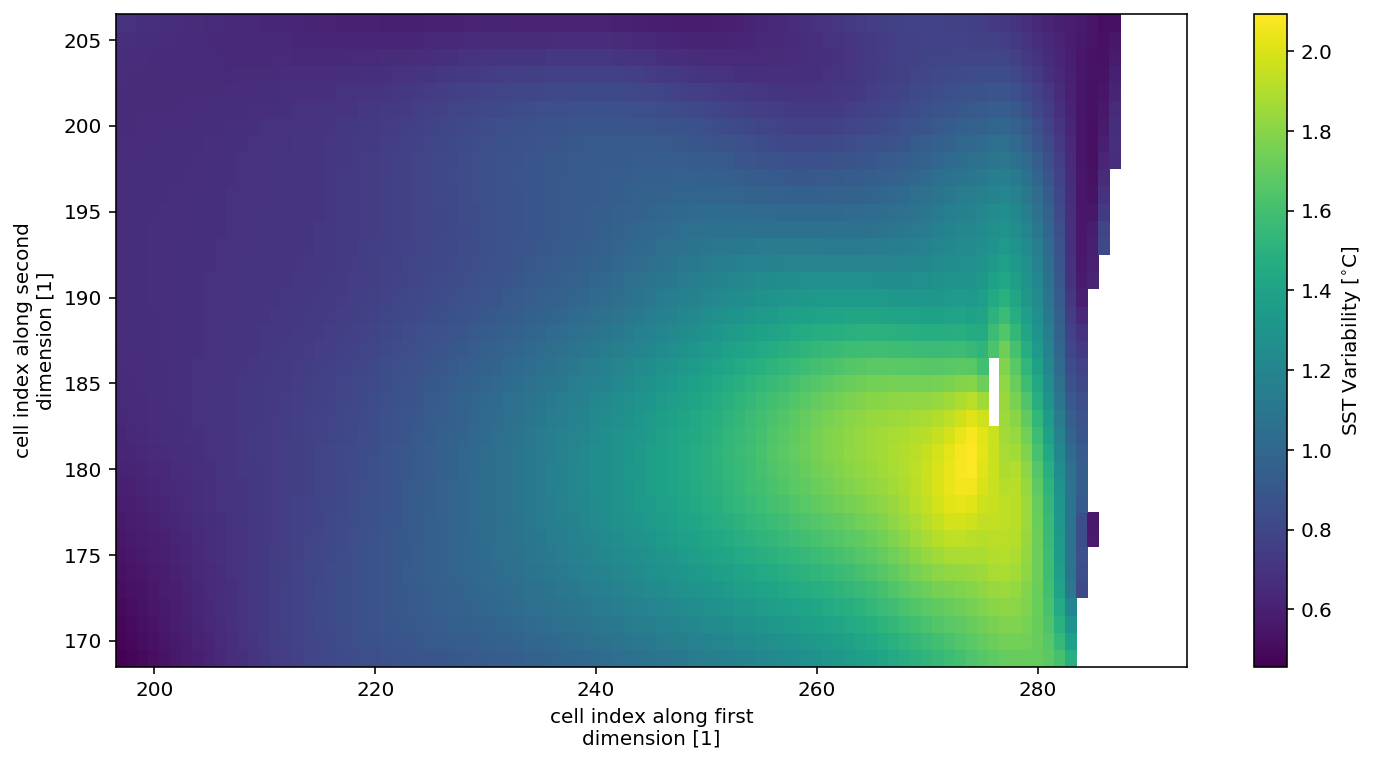

In [113]:
# fig, ax = plt.subplots(figsize=(12,4),dpi=100,ncols=2,nrows=1)
tos_std.plot()

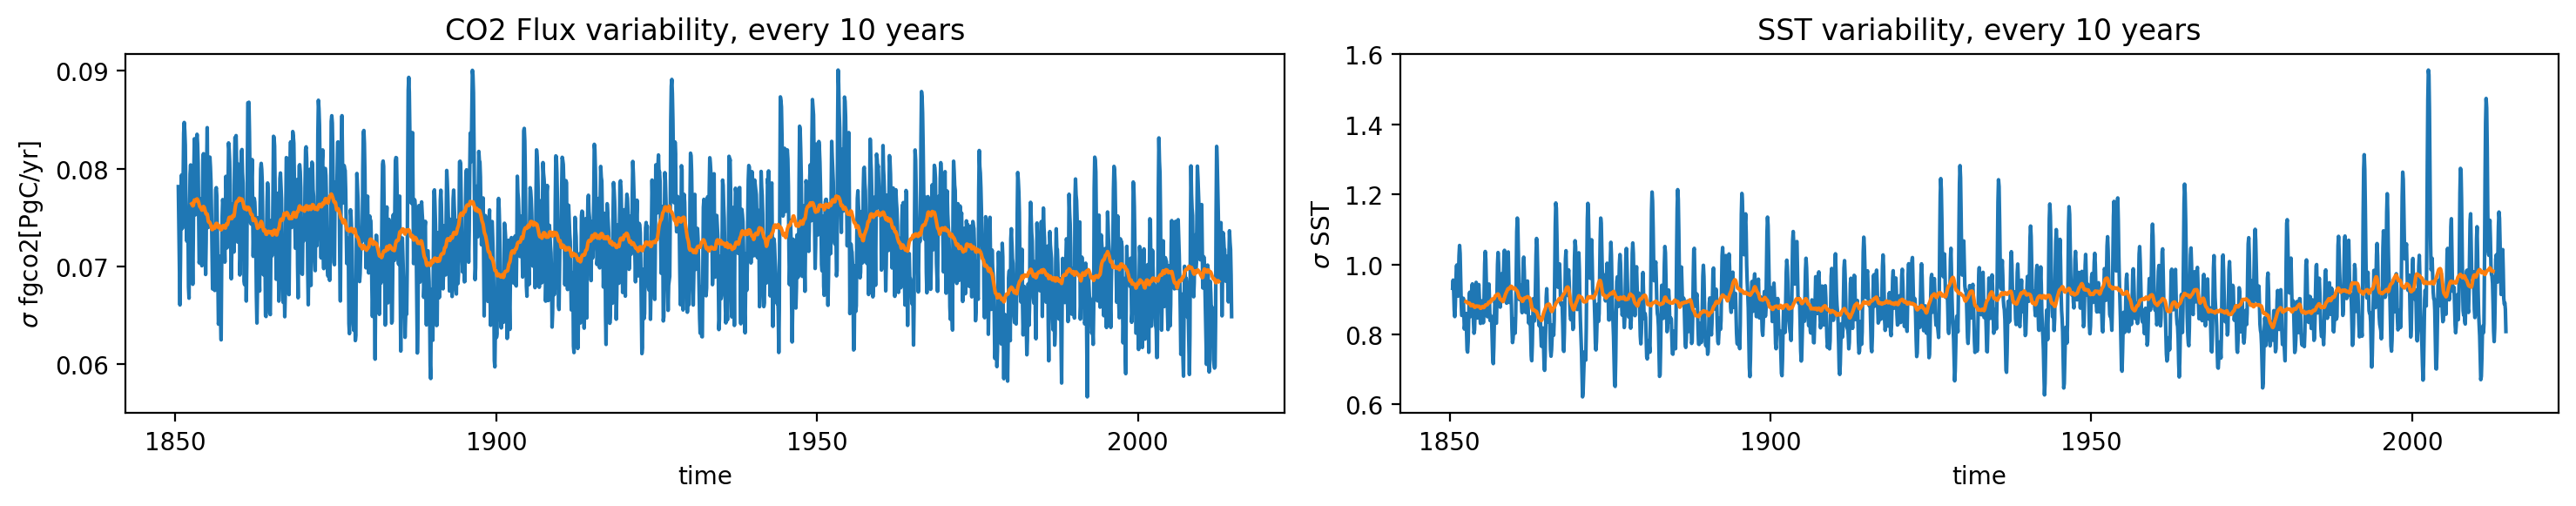

In [171]:
fig, ax = plt.subplots(dpi=100,figsize=(15,3),nrows=1,ncols=2)

fgco2_std_rolling = ds2.fgco2.rolling(time=10,center=True).std(dim='time').mean(dim=['nlat','nlon']).load()
fgco2_std_rolling.plot(ax=ax[0])
fgco2_std_rolling.rolling(time=50,center=True).mean().plot(ax=ax[0])

tos_std_rolling = ds.tos.rolling(time=10,center=True).std(dim='time').mean(dim=['nlat','nlon']).load()
tos_std_rolling.plot(ax=ax[1])
tos_std_rolling.rolling(time=50,center=True).mean().plot(ax=ax[1])

ax[0].set_title('CO2 Flux variability, every 10 years')
ax[0].set_ylabel('$\sigma$ fgco2[PgC/yr]')
ax[1].set_title('SST variability, every 10 years')
ax[1].set_ylabel('$\sigma$ SST')

plt.tight_layout()

# Periodogram for CO2 data

In [176]:
f,Pxx = signal.periodogram(fgco2_std_rolling.dropna(dim='time'))

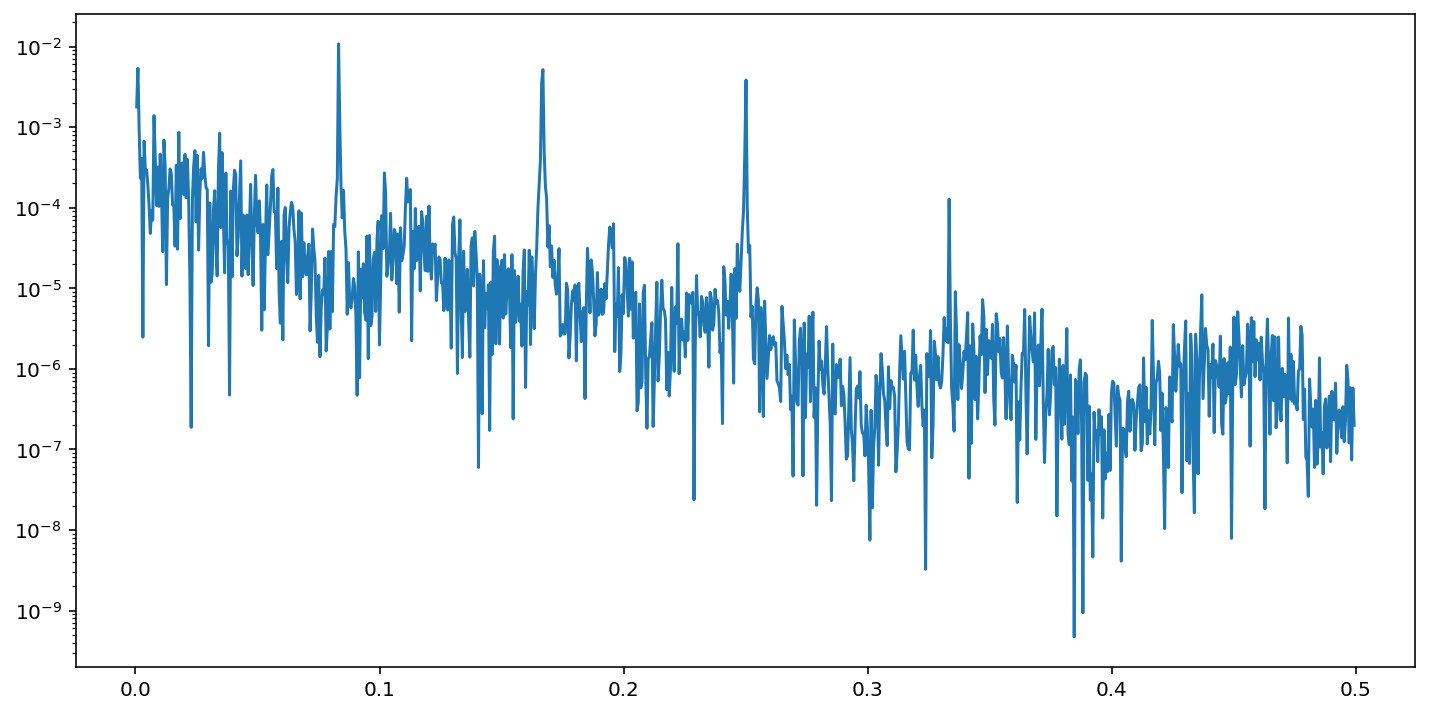

In [180]:
plt.semilogy(f[1:-1],Pxx[1:-1])

In [196]:
signal.find_peaks(Pxx,1e-3)

(array([  2,  15, 164, 329, 493]),
 {'peak_heights': array([0.00536394, 0.00139151, 0.0107943 , 0.00517222, 0.0038498 ])})

In [209]:
f[493]-f[329],f[329]-f[164],f[164]-f[2]
# These peaks are at multiples (harmonics) of the frequency f[2] ~ 0.001

(0.08320649416539827, 0.0837138508371385, 0.0821917808219178)

In [216]:
period = 1/f[2] # in units of months
print(period / 12,f'years periodicity')

82.125 years periodicity


# Cross-correlation between fgco2 and SST

In [240]:
corr = signal.correlate(info['CESM2']['1yr_mean_tos'].dropna(dim='time'),info['CESM2']['1yr_mean_fgco2'].dropna(dim='time'),'full')

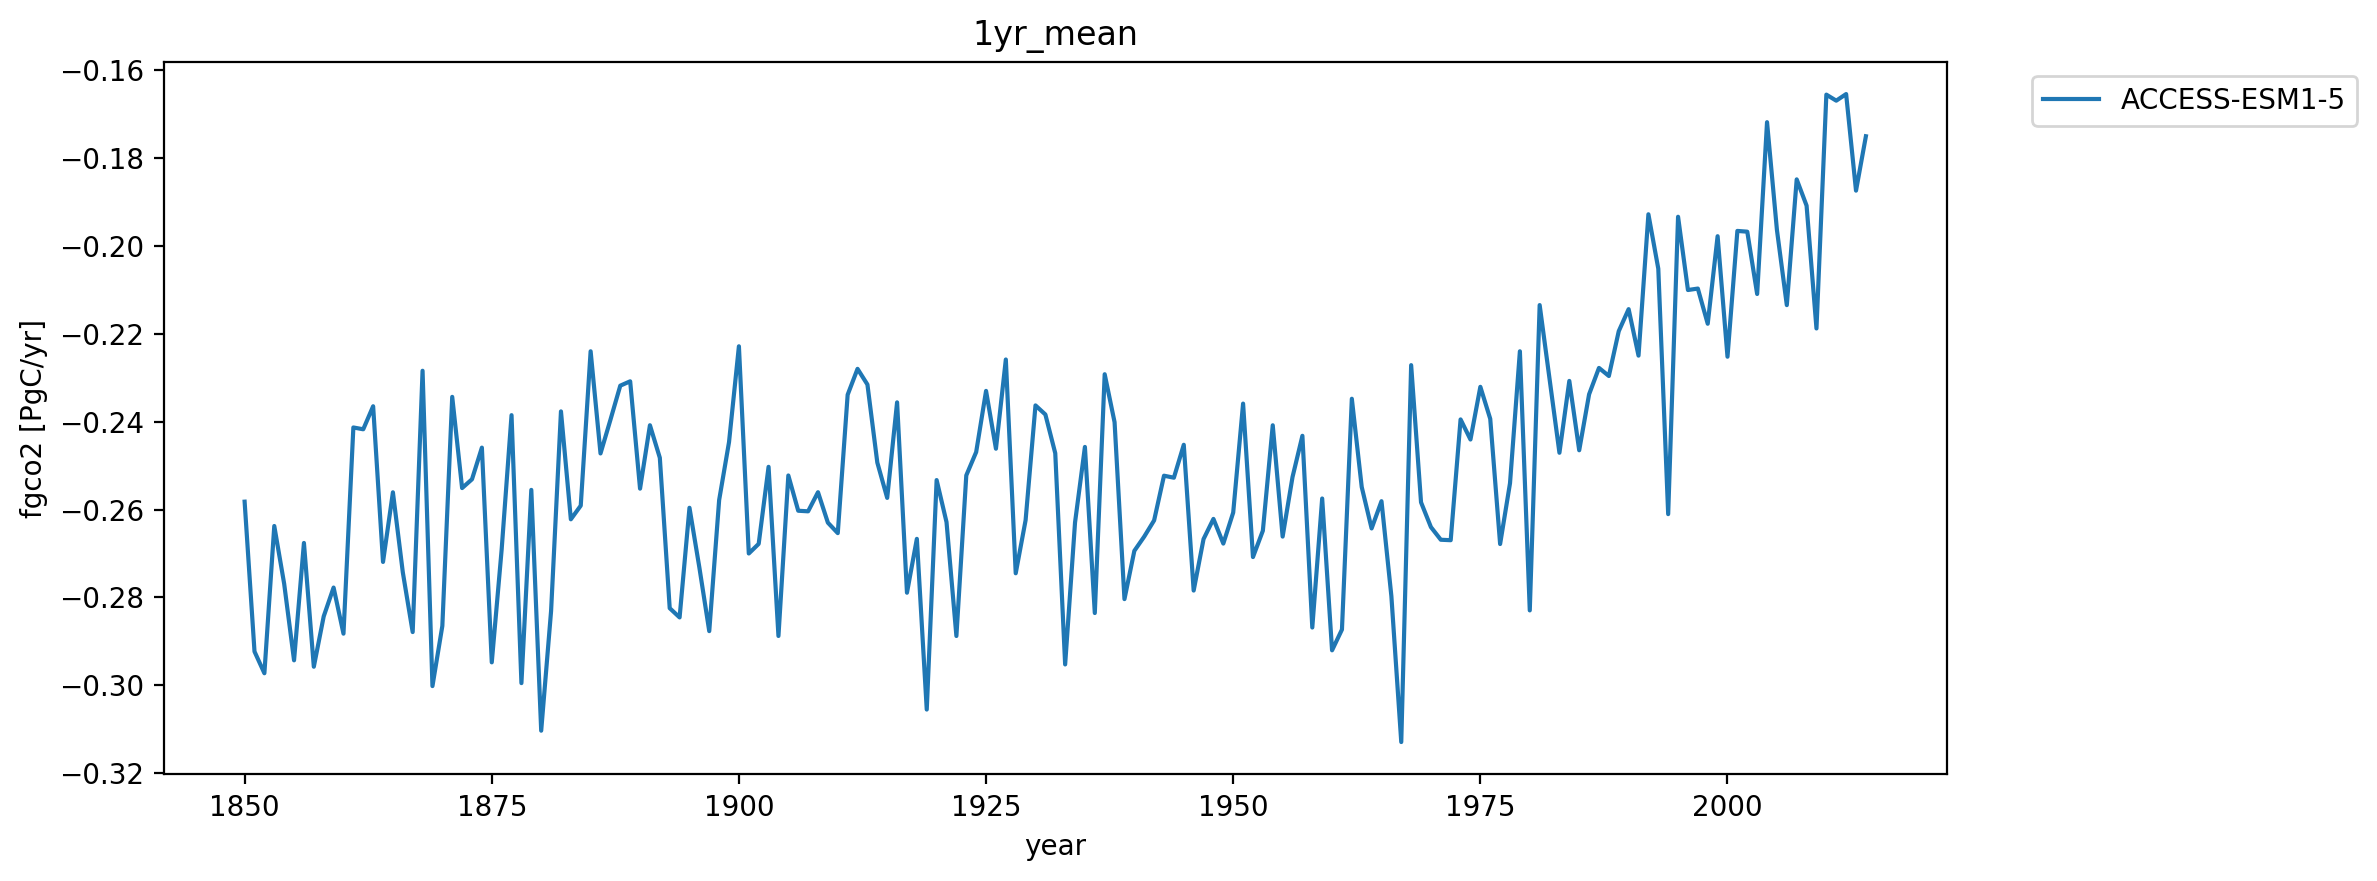

In [118]:
trend = '1yr_mean'

fig, ax = plt.subplots(figsize=(12,4.5),dpi=100)

plt.plot(info['ACCESS-ESM1-5'][trend],label='ACCESS-ESM1-5')
# plt.plot(info['CESM2'][trend],label='CESM2')
# plt.plot(info['CESM2-FV2'][trend],label='CESM2-FV2')
# plt.plot(info['CESM2-WACCM'][trend],label='CESM2-WACCM')
# plt.plot(info['CESM2-WACCM-FV2'][trend],label='CESM2-WACCM-FV2')
# plt.plot(info['CNRM-ESM2-1'][trend],label='CNRM-ESM2-1')
# plt.plot(info['CanESM5'][trend],label='CanESM5')
# plt.plot(info['CanESM5-CanOE'][trend],label='CanESM5-CanOE')
# plt.plot(info['IPSL-CM6A-LR'][trend],label='IPSL-CM6A-LR')
# plt.plot(info['MIROC-ES2L'][trend], label='MIROC-ES2L')
# plt.plot(info['MPI-ESM-1-2-HAM'][trend],label='MPI-ESM-1-2-HAM',ls='--')
# plt.plot(info['MPI-ESM1-2-HR'][trend],label='MPI-ESM1-2-HR',ls='--')
# plt.plot(info['MPI-ESM1-2-LR'][trend],label='MPI-ESM1-2-LR',ls='--')
# plt.plot(info['MRI-ESM2-0'][trend], label='MRI-ESM2-0',ls='--')
# plt.plot(info['NorESM2-LM'][trend],label='NorESM2-LM',ls='--')
# plt.plot(info['NorESM2-MM'][trend],label='NorESM2-MM',ls='--')

# # GISS models are a magnitude larger
# # plt.plot(info['GISS-E2-1-G'][trend],label='GISS-E2-1-G')
# # plt.plot(info['GISS-E2-1-G-CC'][trend],label='GISS-E2-1-G-CC')

# # Extended time series model? ignore for now
# # plt.plot(info['NorCPM1'][trend],label='NorCPM1',ls='--')
# BCC models had no values

# 1 year mean ticks
plt.xticks(np.arange(0,166,25), labels=[1850,1875,1900,1925,1950,1975,2000])

plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")

plt.xlabel('year')
plt.ylabel('fgco2 [PgC/yr]')
plt.title(trend)
plt.tight_layout()
# plt.savefig('70yr_movingmean_fgco2_CMIP6')

Text(0.5, 1, '10yr_mean')

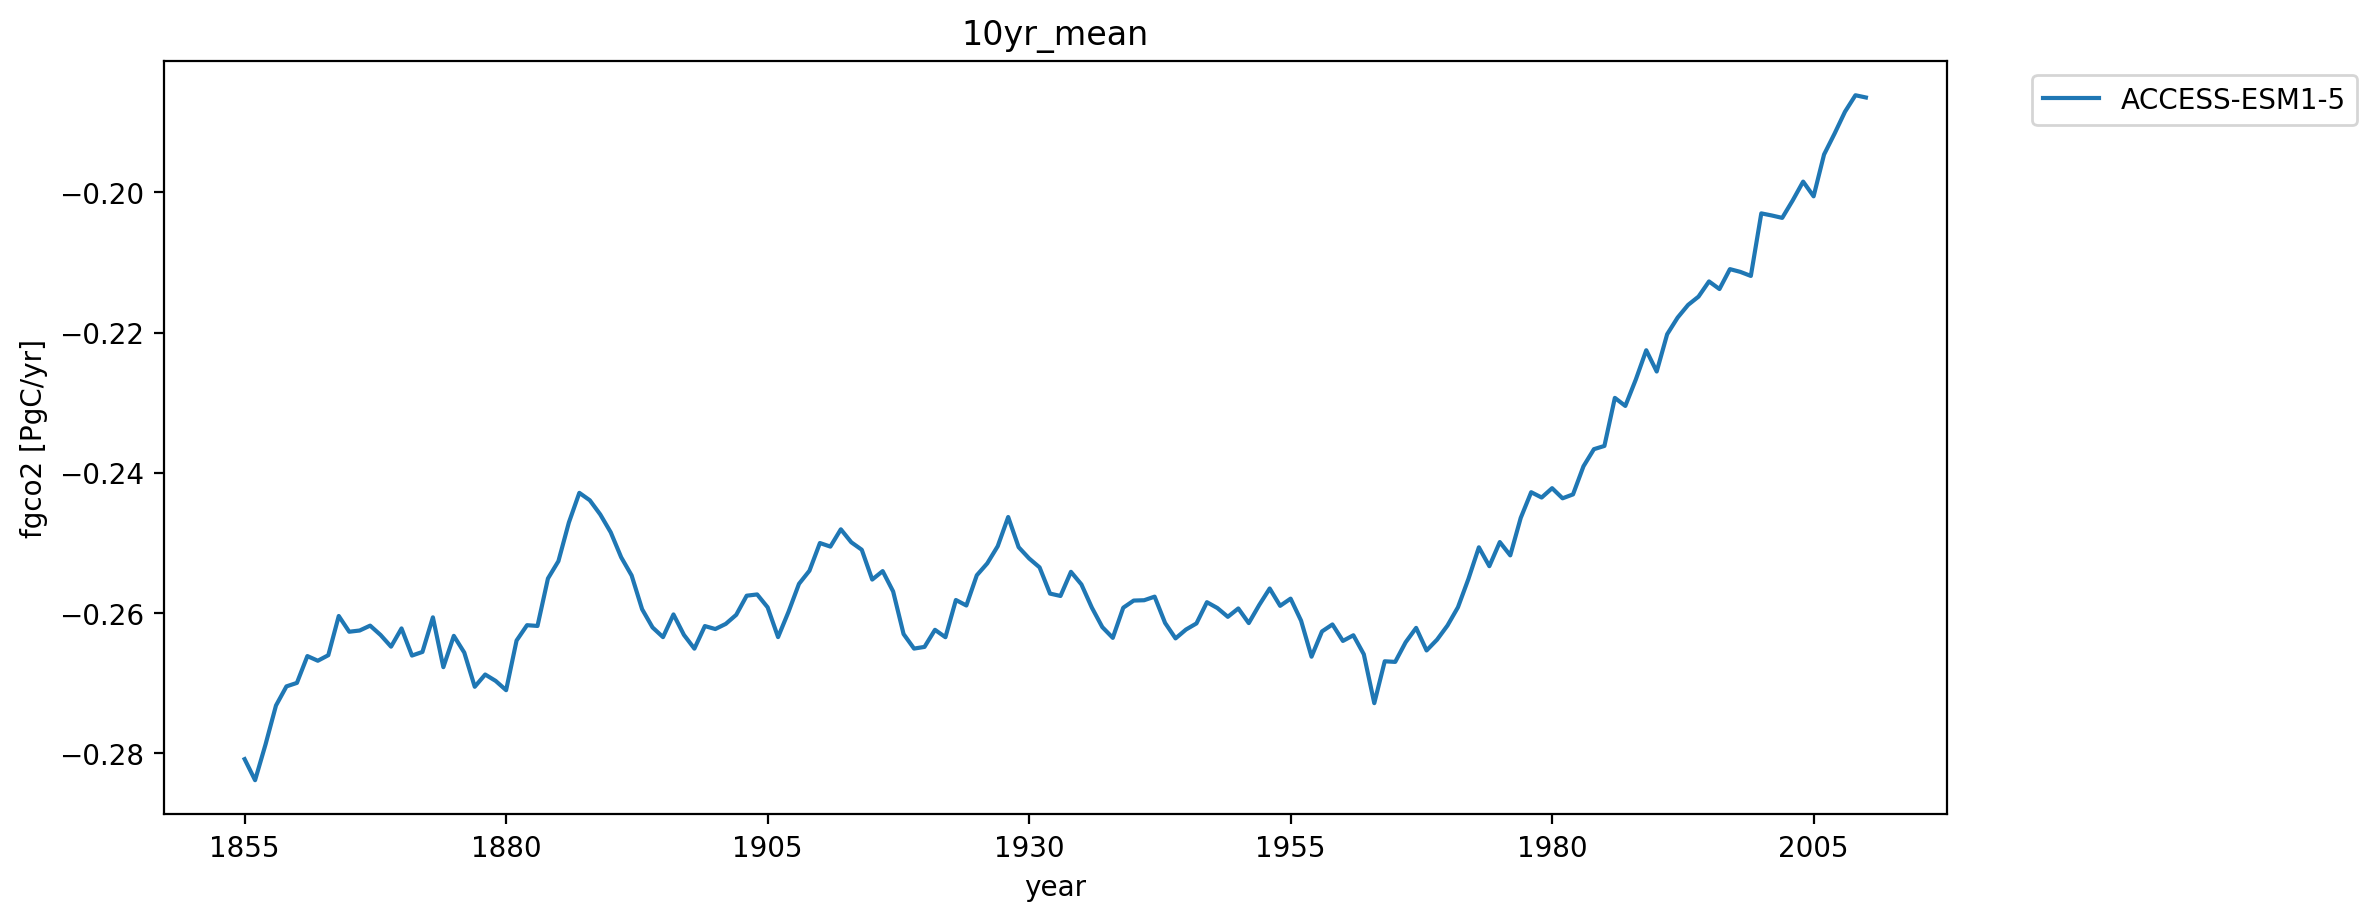

In [119]:
trend = '10yr_mean'

fig, ax = plt.subplots(figsize=(12,4.5),dpi=100)

plt.plot(info['ACCESS-ESM1-5'][trend],label='ACCESS-ESM1-5')
# plt.plot(info['CESM2'][trend],label='CESM2')
# plt.plot(info['CESM2-FV2'][trend],label='CESM2-FV2')
# plt.plot(info['CESM2-WACCM'][trend],label='CESM2-WACCM')
# plt.plot(info['CESM2-WACCM-FV2'][trend],label='CESM2-WACCM-FV2')
# plt.plot(info['CNRM-ESM2-1'][trend],label='CNRM-ESM2-1')
# plt.plot(info['CanESM5'][trend],label='CanESM5')
# plt.plot(info['CanESM5-CanOE'][trend],label='CanESM5-CanOE')
# plt.plot(info['IPSL-CM6A-LR'][trend],label='IPSL-CM6A-LR')
# plt.plot(info['MIROC-ES2L'][trend], label='MIROC-ES2L')
# plt.plot(info['MPI-ESM-1-2-HAM'][trend],label='MPI-ESM-1-2-HAM',ls='--')
# plt.plot(info['MPI-ESM1-2-HR'][trend],label='MPI-ESM1-2-HR',ls='--')
# plt.plot(info['MPI-ESM1-2-LR'][trend],label='MPI-ESM1-2-LR',ls='--')
# plt.plot(info['MRI-ESM2-0'][trend], label='MRI-ESM2-0',ls='--')
# plt.plot(info['NorESM2-LM'][trend],label='NorESM2-LM',ls='--')
# plt.plot(info['NorESM2-MM'][trend],label='NorESM2-MM',ls='--')

# # GISS models are a magnitude larger
# # plt.plot(info['GISS-E2-1-G'][trend],label='GISS-E2-1-G')
# # plt.plot(info['GISS-E2-1-G-CC'][trend],label='GISS-E2-1-G-CC')

# # Extended time series model? ignore for now
# # plt.plot(info['NorCPM1'][trend],label='NorCPM1',ls='--')


# 10 year mean ticks
plt.xticks(np.arange(0,156,25),labels=[1855,1880,1905,1930,1955,1980,2005])

plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")

plt.xlabel('year')
plt.ylabel('fgco2 [PgC/yr]')
plt.tight_layout()
plt.title(trend)
# plt.savefig('70yr_movingmean_fgco2_CMIP6')

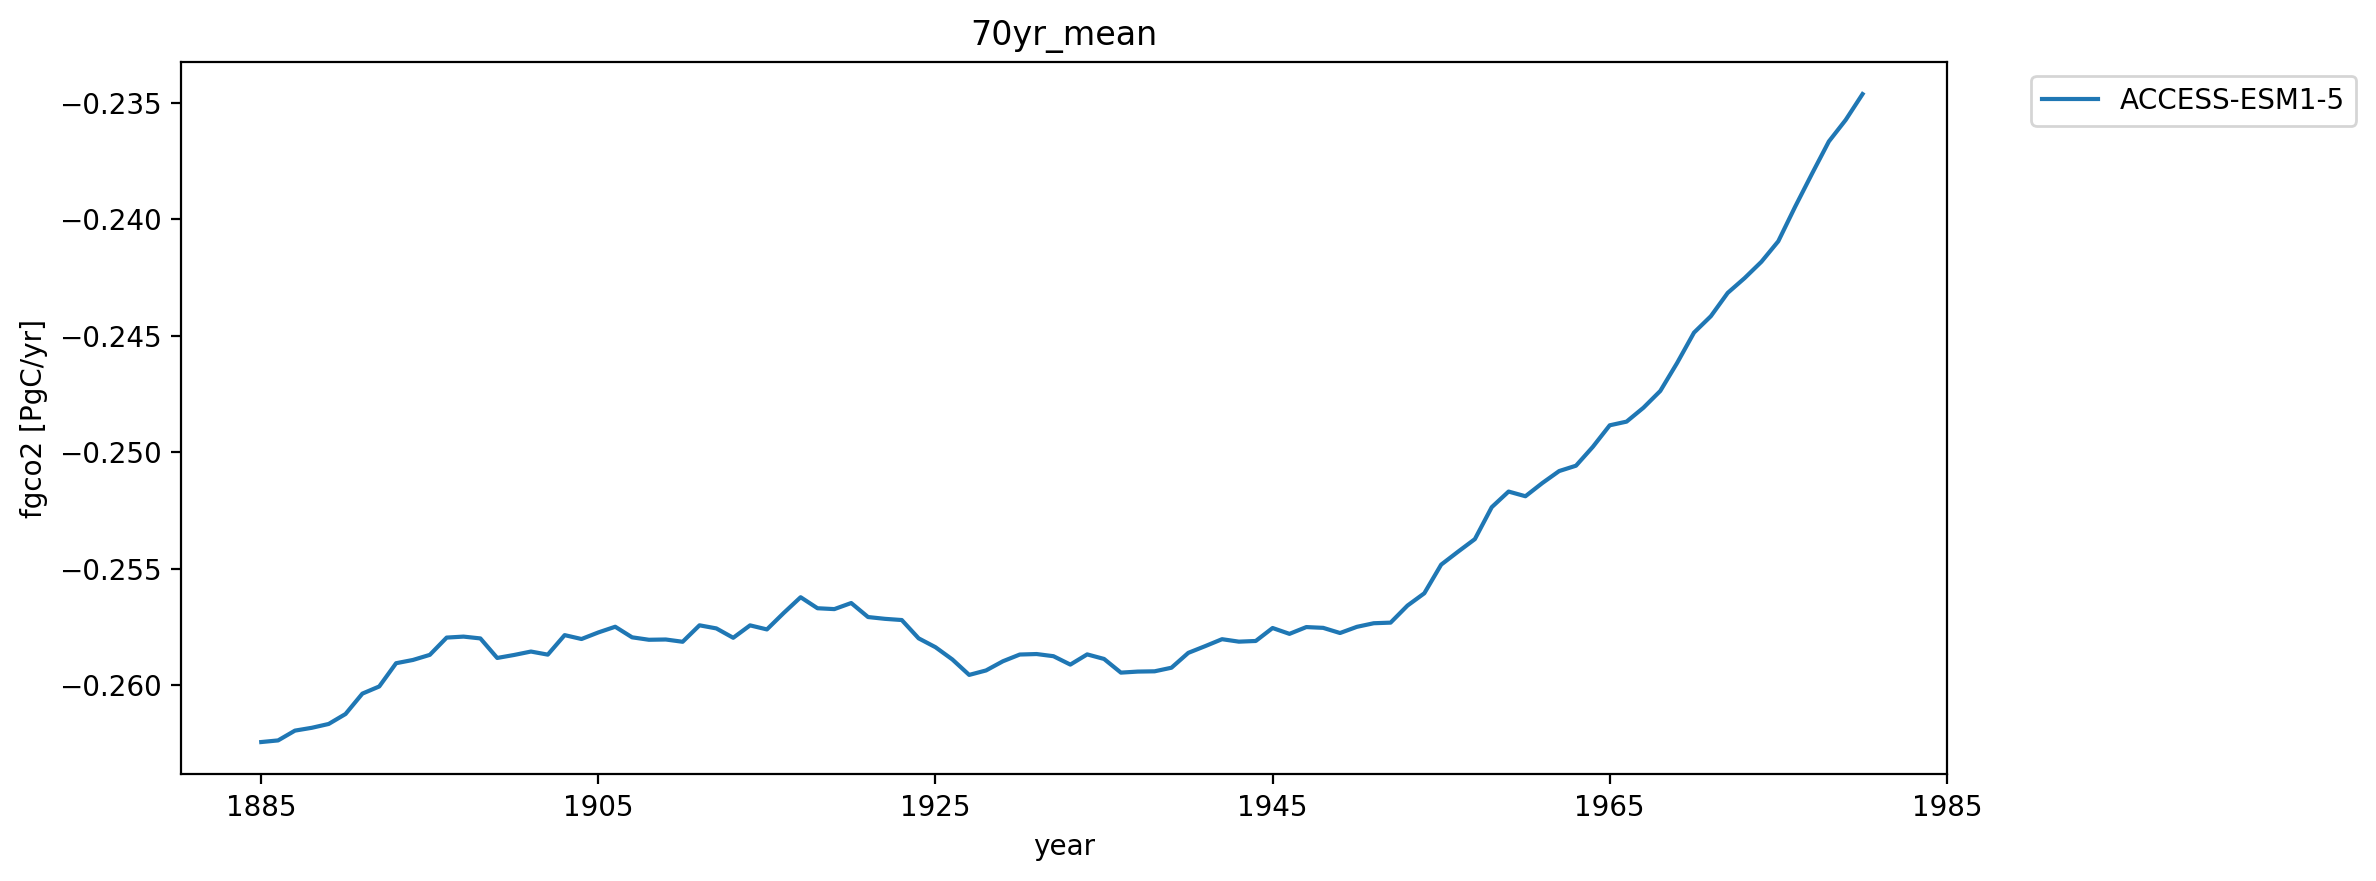

In [120]:
trend = '70yr_mean'

fig, ax = plt.subplots(figsize=(12,4.5),dpi=100)

plt.plot(info['ACCESS-ESM1-5'][trend],label='ACCESS-ESM1-5')
# plt.plot(info['CESM2'][trend],label='CESM2')
# plt.plot(info['CESM2-FV2'][trend],label='CESM2-FV2')
# plt.plot(info['CESM2-WACCM'][trend],label='CESM2-WACCM')
# plt.plot(info['CESM2-WACCM-FV2'][trend],label='CESM2-WACCM-FV2')
# plt.plot(info['CNRM-ESM2-1'][trend],label='CNRM-ESM2-1')
# plt.plot(info['CanESM5'][trend],label='CanESM5')
# plt.plot(info['CanESM5-CanOE'][trend],label='CanESM5-CanOE')
# plt.plot(info['IPSL-CM6A-LR'][trend],label='IPSL-CM6A-LR')
# plt.plot(info['MIROC-ES2L'][trend], label='MIROC-ES2L')
# plt.plot(info['MPI-ESM-1-2-HAM'][trend],label='MPI-ESM-1-2-HAM',ls='--')
# plt.plot(info['MPI-ESM1-2-HR'][trend],label='MPI-ESM1-2-HR',ls='--')
# plt.plot(info['MPI-ESM1-2-LR'][trend],label='MPI-ESM1-2-LR',ls='--')
# plt.plot(info['MRI-ESM2-0'][trend], label='MRI-ESM2-0',ls='--')
# plt.plot(info['NorESM2-LM'][trend],label='NorESM2-LM',ls='--')
# plt.plot(info['NorESM2-MM'][trend],label='NorESM2-MM',ls='--')

# # GISS models are a magnitude larger? ignore for now
# # plt.plot(info['GISS-E2-1-G'][trend],label='GISS-E2-1-G')
# # plt.plot(info['GISS-E2-1-G-CC'][trend],label='GISS-E2-1-G-CC')

# # Extended time series model? ignore for now
# # plt.plot(info['NorCPM1'][trend],label='NorCPM1',ls='--')

# 70 year mean ticks
plt.xticks(np.arange(0,101,20),labels=[1885,1905,1925,1945,1965,1985])

plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")

plt.xlabel('year')
plt.ylabel('fgco2 [PgC/yr]')
plt.title(trend)
plt.tight_layout()
# plt.savefig('70yr_movingmean_fgco2_CMIP6')